In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from pinneit import Rect, plot_geo, exclude_points_in_region

os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

2024-11-06 16:48:56.059912: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-06 16:48:56.727663: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
Ω = Rect(0, 0, 1, 1)
Γ = Rect(0.4, 0.4, 0.2, 0.2)

Got a list of 2 geometries.


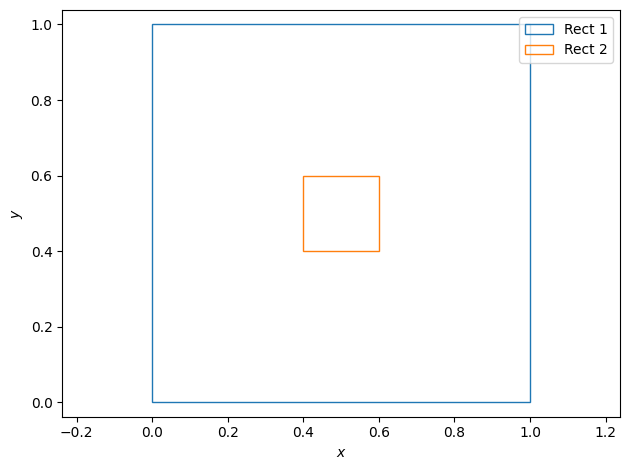

In [3]:
plot_geo([Ω, Γ])

In [4]:
n_points = 100

dΓ_pts = Γ.generate_edge_points(n_pts=n_points)
sΩ_pts = Ω.generate_surface_points(n_pts=500)
sΩ_pts = exclude_points_in_region(sΩ_pts, Γ)
dΩ_pts = Ω.generate_edge_points(n_pts=n_points)

print(dΓ_pts.shape, sΩ_pts.shape, dΩ_pts.shape)

(100, 2) (479, 2) (100, 2)


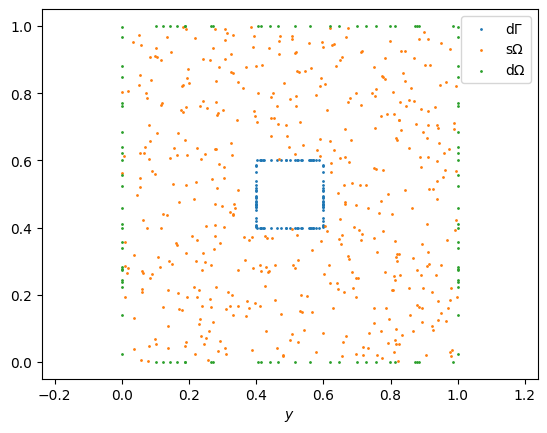

In [5]:
plt.scatter(dΓ_pts[:, 0], dΓ_pts[:, 1], s=1, label="dΓ")
plt.scatter(sΩ_pts[:, 0], sΩ_pts[:, 1], s=1, label="sΩ")
plt.scatter(dΩ_pts[:, 0], dΩ_pts[:, 1], s=1, label="dΩ")
plt.xlabel("$x$")
plt.xlabel("$y$")
plt.axis("equal")
plt.legend()
plt.show()

**Train PINN**
- [PINNS-PDE](https://github.com/hubertbaty/PINNS-PDE/tree/main)

In [6]:
X_b = np.concatenate((dΩ_pts, dΓ_pts))
y_b = np.concatenate(
    (
        np.zeros(dΩ_pts.shape[0]),
        np.ones(dΓ_pts.shape[0]),
    )
)
assert X_b.shape[0] == y_b.shape[0]
shffls_idx = np.random.permutation(y_b.shape[0])

X = X_b[shffls_idx]
y = y_b[shffls_idx]

Pts = tf.constant(sΩ_pts, dtype=tf.float32)
X = tf.constant(X, dtype=tf.float32)
y = tf.constant(y, dtype=tf.float32)

2024-11-06 16:49:02.013224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8476 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2024-11-06 16:49:02.015770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 64568 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:0a:00.0, compute capability: 8.0


In [7]:
Pts.shape, X.shape, y.shape

(TensorShape([479, 2]), TensorShape([200, 2]), TensorShape([200]))

In [8]:
X_f, X_b, y_b = Pts, X, y

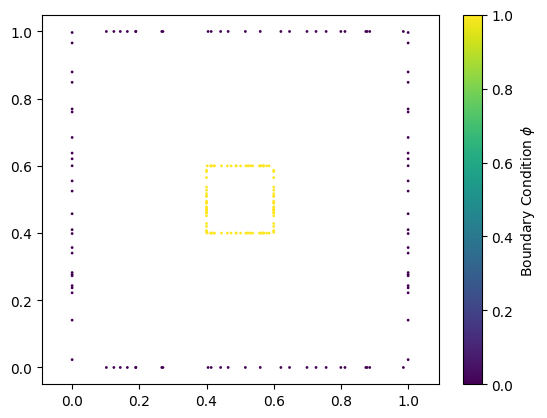

In [9]:
plt.scatter(X_b[:, 0], X_b[:, 1], c=y_b, s=1)
plt.axis("equal")
plt.colorbar(label="Boundary Condition $\phi$")
plt.show()

In [10]:
# Define the neural network model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(28, activation="tanh")
        self.dense2 = tf.keras.layers.Dense(28, activation="tanh")
        self.dense3 = tf.keras.layers.Dense(28, activation="tanh")

        self.dense7 = tf.keras.layers.Dense(1, activation=None)

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        # x = self.dense4(x)
        # x = self.dense5(x)
        # x = self.dense6(x)
        x = self.dense7(x)
        return x


lambda1, lambda2 = 1, 1e-3


# Define the loss function
@tf.function
def compute_loss(model, X_f, X_b, y_b):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch(X_f)
        phi = model(X_f)
        phi_x = tape1.gradient(phi, X_f)[:, 0:1]
        phi_y = tape1.gradient(phi, X_f)[:, 1:2]
    phi_xx = tape1.gradient(phi_x, X_f)[:, 0:1]
    phi_yy = tape1.gradient(phi_y, X_f)[:, 1:2]
    del tape1

    f_residual = phi_xx + phi_yy
    pde_loss = tf.reduce_mean(tf.square(f_residual))

    # Boundary Condition Loss
    phi_b = model(X_b)
    bc_loss = tf.reduce_mean(tf.square(phi_b - y_b))

    # Total Loss
    total_loss = lambda2 * pde_loss + lambda1 * bc_loss
    return total_loss, pde_loss, bc_loss


# Example usage
model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

Epoch 0, Total Loss: 0.6826901435852051, PDE Loss: 0.0032430700957775116, BC Loss: 0.6826869249343872
Epoch 500, Total Loss: 0.2500055134296417, PDE Loss: 0.0021593072451651096, BC Loss: 0.2500033676624298
Epoch 1000, Total Loss: 0.250000923871994, PDE Loss: 0.0006094833370298147, BC Loss: 0.25000032782554626
Epoch 1500, Total Loss: 0.25000062584877014, PDE Loss: 0.0004719361022580415, BC Loss: 0.25000014901161194
Epoch 2000, Total Loss: 0.2500004470348358, PDE Loss: 0.0003706258721649647, BC Loss: 0.25000008940696716
Epoch 2500, Total Loss: 0.25000032782554626, PDE Loss: 0.0002806950069498271, BC Loss: 0.2500000596046448
Epoch 3000, Total Loss: 0.2500002682209015, PDE Loss: 0.00020438495266716927, BC Loss: 0.2500000596046448
Epoch 3500, Total Loss: 0.2500002086162567, PDE Loss: 0.00014292918785940856, BC Loss: 0.2500000596046448
Epoch 4000, Total Loss: 0.2500001788139343, PDE Loss: 0.00011206279305042699, BC Loss: 0.2500000596046448
Epoch 4500, Total Loss: 0.2500000596046448, PDE Loss

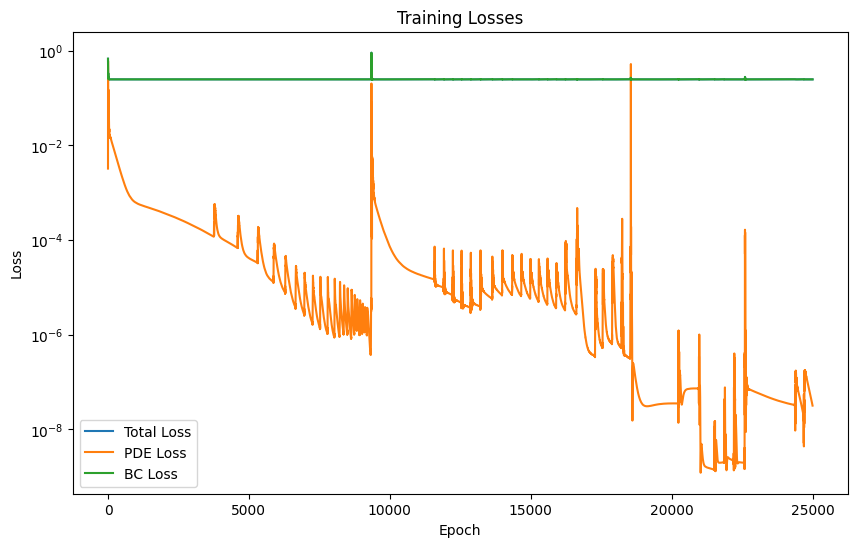

In [11]:
# Training step
@tf.function
def train_step():
    with tf.GradientTape() as tape:
        total_loss, pde_loss, bc_loss = compute_loss(model, X_f, X_b, y_b)
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return total_loss, pde_loss, bc_loss


# Training loop
epochs = 25_000
loss_history = []
pde_loss_history = []
bc_loss_history = []

for epoch in range(epochs):
    total_loss, pde_loss, bc_loss = train_step()
    loss_history.append(total_loss.numpy())
    pde_loss_history.append(pde_loss.numpy())
    bc_loss_history.append(bc_loss.numpy())
    if epoch % 500 == 0:
        print(
            f"Epoch {epoch}, Total Loss: {total_loss.numpy()}, PDE Loss: {pde_loss.numpy()}, BC Loss: {bc_loss.numpy()}"
        )

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Total Loss")
plt.plot(pde_loss_history, label="PDE Loss")
plt.plot(bc_loss_history, label="BC Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

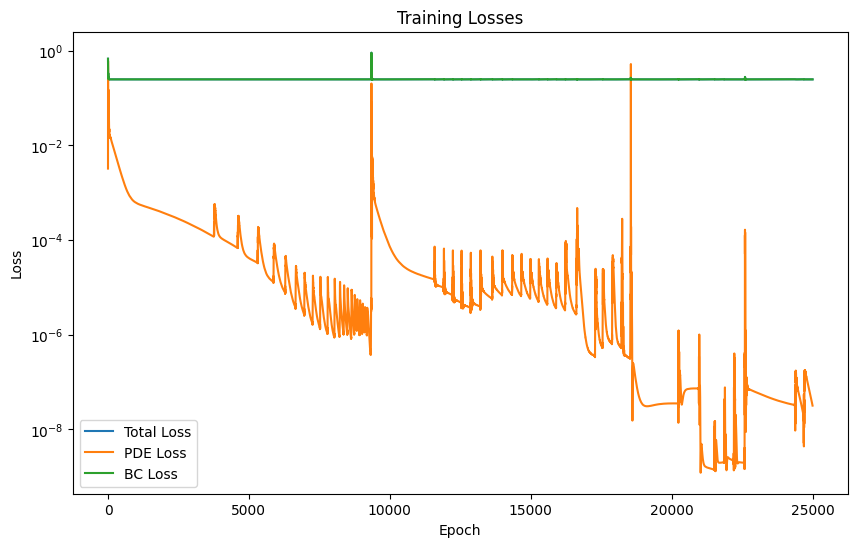

In [12]:
# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(loss_history, label="Total Loss")
plt.plot(pde_loss_history, label="PDE Loss")
plt.plot(bc_loss_history, label="BC Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

In [13]:
pinn_predictions_filtered = model(tf.constant(Pts, dtype=tf.float32)).numpy()

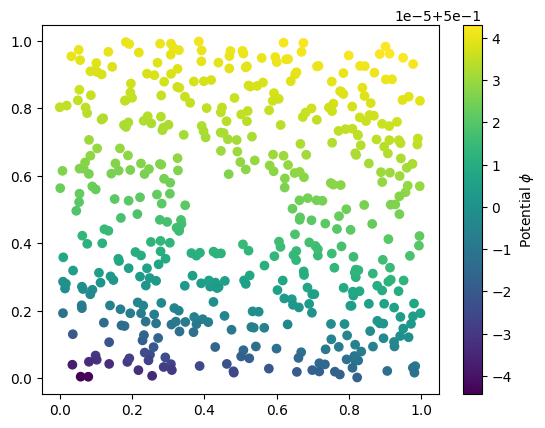

In [14]:
plt.scatter(Pts[:, 0], Pts[:, 1], c=pinn_predictions_filtered.flatten())
plt.colorbar(label="Potential $\phi$")
plt.show()